# MBConv

In [1]:
import os
import pandas as pd
import numpy as np
import time

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, Dataset
from torchmetrics.classification import MulticlassConfusionMatrix, MulticlassPrecision, MulticlassRecall, MulticlassF1Score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report 

## Loading Dataset

In [2]:
path = os.path.realpath('data/animal_10')
list_path = path.split('/')
list_path.remove('animal_cnn')
list_path.remove('animal-project')
path_training = os.path.join('/'.join(list_path), 'raw-img_training')
path_training

'/home/viviane/projects/data/animal_10/raw-img_training'

In [3]:
dataset = datasets.ImageFolder(
    root=path_training, 
    transform=transforms.ToTensor()
)
classes = dataset.classes
print(classes)

['butterfly', 'cat', 'cow', 'dog', 'elephant', 'hen', 'horse', 'sheep', 'spider', 'squirrel']


In [4]:
path = os.path.realpath('data/animal_10')
list_path = path.split('/')
list_path.remove('animal_cnn')
list_path.remove('animal-project')
path_val = os.path.join('/'.join(list_path), 'raw_img_test')
path_val

'/home/viviane/projects/data/animal_10/raw_img_test'

## Preprocessing

In [5]:
# Define paths for your training and validation datasets
train_dir = path_training
val_dir = path_val

# Define image size and batch size
IMAGE_SIZE = 224
BATCH_SIZE = 8

# Define data augmentation for the training dataset
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),   # Random crop and resize
    transforms.RandomHorizontalFlip(p=0.5),     # Random horizontal flip
    transforms.RandomRotation(20),              # Random rotation within ±20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, shear=10, scale=(0.8, 1.2)),  # Shearing
    transforms.ToTensor(),                      # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize
])

# Validation dataset transformations (no augmentation, only resizing and normalization)
val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# Load datasets
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(root=val_dir, transform=val_transforms)

train_size = int(0.8 * len(train_dataset))  # 80% for training
test_size = len(train_dataset) - train_size  # Remaining for testing

train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}, Validation samples: {len(val_dataset)}')


Training samples: 10472, Test samples: 2619, Validation samples: 13091


In [6]:
print(f'Training samples: {len(train_loader)}, Test samples: {len(test_loader)}, Validation samples: {len(val_loader)}')

Training samples: 1309, Test samples: 328, Validation samples: 1637


In [7]:
## CNN architecture

In [8]:
class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expansion=6, stride=1):
        super(MBConvBlock, self).__init__()
        mid_channels = in_channels * expansion
        self.expand = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False) if expansion != 1 else None
        self.dwconv = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=1, groups=mid_channels, bias=False)
        self.project = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Skip connection
        self.use_residual = stride == 1 and in_channels == out_channels

    def forward(self, x):
        identity = x
        if self.expand:
            x = self.relu(self.bn1(self.expand(x)))
        x = self.relu(self.bn1(self.dwconv(x)))
        x = self.bn2(self.project(x))
        if self.use_residual:
            x += identity
        return x

In [9]:
class EfficientNetBlock(nn.Module):
    def __init__(self, num_classes=10):
        super(EfficientNetBlock, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.SiLU()
        )
        
        self.blocks = nn.Sequential(
            MBConvBlock(32, 16, expansion=1, stride=1),
            MBConvBlock(16, 24, expansion=6, stride=2),
            MBConvBlock(24, 40, expansion=6, stride=2)
        )
        
        self.head = nn.Sequential(
            nn.Conv2d(40, 1280, kernel_size=1, bias=False),
            nn.BatchNorm2d(1280),
            nn.SiLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(1280, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        return x

## Training model

In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Metrics from torchmetrics
    confusion_matrix = MulticlassConfusionMatrix(num_classes=10)
    precision = MulticlassPrecision(num_classes=10, average='macro')
    recall = MulticlassRecall(num_classes=10, average='macro')
    f1_score = MulticlassF1Score(num_classes=10, average='macro')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100 * correct_train / total_train)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (preds == labels).sum().item()

                # For metrics
                all_preds.append(preds.cpu())
                all_labels.append(labels.cpu())

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct_val / total_val)

        # Combine predictions and labels
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)

        # Calculate torchmetrics
        precision_value = precision(all_preds, all_labels)
        recall_value = recall(all_preds, all_labels)
        f1_value = f1_score(all_preds, all_labels)
        conf_matrix = confusion_matrix(all_preds, all_labels)

        # Print epoch statistics
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.2f}%")
        print(f"Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accuracies[-1]:.2f}%")
        print(f"Precision: {precision_value:.4f} | Recall: {recall_value:.4f} | F1 Score: {f1_value:.4f}\n")

    return train_losses, val_losses, train_accuracies, val_accuracies, conf_matrix

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 10

# Instantiate the model
model = EfficientNetBlock(num_classes=num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


In [12]:
summary(model, input_size=(BATCH_SIZE, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
EfficientNetBlock                        [8, 10]                   --
├─Sequential: 1-1                        [8, 32, 112, 112]         --
│    └─Conv2d: 2-1                       [8, 32, 112, 112]         864
│    └─BatchNorm2d: 2-2                  [8, 32, 112, 112]         64
│    └─SiLU: 2-3                         [8, 32, 112, 112]         --
├─Sequential: 1-2                        [8, 40, 28, 28]           --
│    └─MBConvBlock: 2-4                  [8, 16, 112, 112]         --
│    │    └─Conv2d: 3-1                  [8, 32, 112, 112]         288
│    │    └─BatchNorm2d: 3-2             [8, 32, 112, 112]         64
│    │    └─ReLU: 3-3                    [8, 32, 112, 112]         --
│    │    └─Conv2d: 3-4                  [8, 16, 112, 112]         512
│    │    └─BatchNorm2d: 3-5             [8, 16, 112, 112]         32
│    └─MBConvBlock: 2-5                  [8, 24, 56, 56]           --
│    │    └─

In [13]:
t1 = time.time()
print(f"Using device: {device}")

train_losses, val_losses, train_accuracies, val_accuracies, conf_matrix = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=10)

print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Using device: cuda
Epoch 1/10
Train Loss: 2.1115 | Train Acc: 23.80%
Val Loss: 2.2467 | Val Acc: 23.56%
Precision: 0.1001 | Recall: 0.1440 | F1 Score: 0.0968

Epoch 2/10
Train Loss: 1.9758 | Train Acc: 29.21%
Val Loss: 2.4642 | Val Acc: 26.92%
Precision: 0.1498 | Recall: 0.1535 | F1 Score: 0.0978

Epoch 3/10
Train Loss: 1.8988 | Train Acc: 32.65%
Val Loss: 2.5442 | Val Acc: 13.55%
Precision: 0.2641 | Recall: 0.1497 | F1 Score: 0.0989

Epoch 4/10
Train Loss: 1.8431 | Train Acc: 34.85%
Val Loss: 2.8664 | Val Acc: 19.05%
Precision: 0.0964 | Recall: 0.1225 | F1 Score: 0.0694

Epoch 5/10
Train Loss: 1.7914 | Train Acc: 36.77%
Val Loss: 3.0013 | Val Acc: 12.83%
Precision: 0.1942 | Recall: 0.1519 | F1 Score: 0.0899

Epoch 6/10
Train Loss: 1.7546 | Train Acc: 38.23%
Val Loss: 3.0549 | Val Acc: 11.99%
Precision: 0.2142 | Recall: 0.1503 | F1 Score: 0.0865

Epoch 7/10
Train Loss: 1.7324 | Train Acc: 39.07%
Val Loss: 3.4706 | Val Acc: 12.56%
Precision: 0.1946 | Recall: 0.1607 | F1 Score: 0.0874

E

## Evaluating

In [14]:
model.eval() 

with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Test Accuracy of the model on the {total} test images: {(correct / total) * 100:.2f}%')

Test Accuracy of the model on the 2619 test images: 11.11%


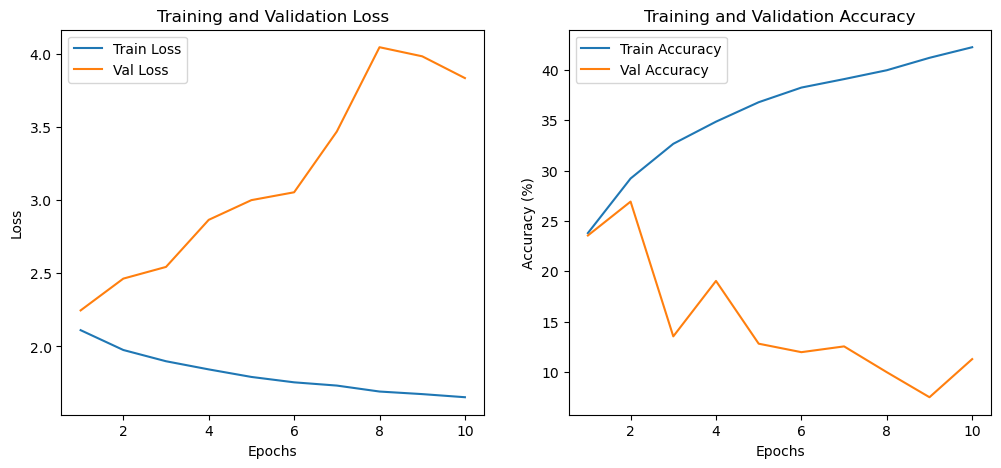

In [15]:
def plot_training(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

plot_training(train_losses, val_losses, train_accuracies, val_accuracies)

In [16]:
### Confusion Matrix

In [17]:
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
tensor([[ 12,  54,   0,   2,   0,   0,   0,   2,   0, 138],
        [  0, 126,   0,   0,   0,   1,   0,   0,   0,  55],
        [  2,  88,   0,   0,   0,   9,   0,   0,   0,  90],
        [  0, 286,   0,   1,   0,  13,   0,   0,   0, 167],
        [  3,  78,   0,   1,   0,  11,   0,   0,   0,  47],
        [  2, 135,   0,   0,   0,  39,   0,   2,   0, 134],
        [  0, 125,   0,   3,   0,  10,   0,   0,   0, 116],
        [  0,  69,   0,   0,   0,  10,   0,   3,   0,  99],
        [  1, 253,   0,   2,   0,  14,   0,   0,   0, 226],
        [  0,  65,   0,   0,   0,   9,   0,   1,   0, 115]])


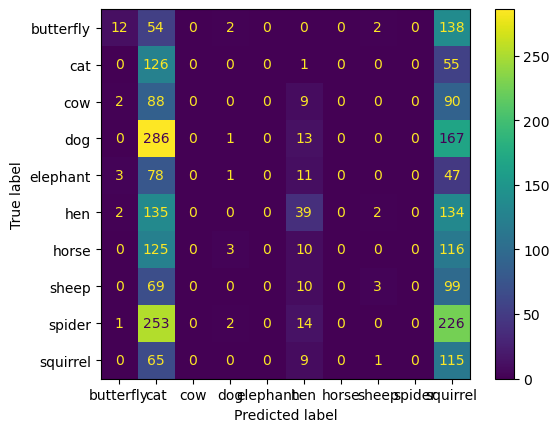

In [18]:
cm = conf_matrix.cpu().numpy()
disp = ConfusionMatrixDisplay(cm, display_labels=classes,)
disp.plot()

### Metrics

In [19]:
precision = MulticlassPrecision(num_classes=num_classes, average=None)
recall = MulticlassRecall(num_classes=num_classes, average=None)
f1_score = MulticlassF1Score(num_classes=num_classes, average=None)

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)


per_class_precision = precision(all_preds, all_labels)
per_class_recall = recall(all_preds, all_labels)
per_class_f1 = f1_score(all_preds, all_labels)


for i, name in enumerate(classes):
    print(f"Class {i}-{name}: Precision: {per_class_precision[i]:.2f}, Recall: {per_class_recall[i]:.2f}, F1-Score: {per_class_f1[i]:.2f}")

Class 0-butterfly: Precision: 0.41, Recall: 0.04, F1-Score: 0.08
Class 1-cat: Precision: 0.09, Recall: 0.57, F1-Score: 0.16
Class 2-cow: Precision: 0.00, Recall: 0.00, F1-Score: 0.00
Class 3-dog: Precision: 0.14, Recall: 0.01, F1-Score: 0.02
Class 4-elephant: Precision: 0.00, Recall: 0.00, F1-Score: 0.00
Class 5-hen: Precision: 0.29, Recall: 0.34, F1-Score: 0.31
Class 6-horse: Precision: 0.00, Recall: 0.00, F1-Score: 0.00
Class 7-sheep: Precision: 0.17, Recall: 0.01, F1-Score: 0.02
Class 8-spider: Precision: 0.00, Recall: 0.00, F1-Score: 0.00
Class 9-squirrel: Precision: 0.11, Recall: 0.65, F1-Score: 0.18
